# GARCH Model Testing

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
import sklearn
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.preprocessing import StandardScaler


In [22]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')
print(df.head())
print(df.columns.tolist())

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

       Month   Bitcoin   Tether  Litecoin       XRP  Ethereum  Dogecoin  \
0 2017-09-01 -1.398923 -3.82830  -1.02849 -0.898590 -1.320943 -1.405018   
1 2017-10-01 -1.339539 -3.73861  -0.77151 -1.145490 -0.837982 -0.464897   
2 2017-11-01 -1.622995 -4.01951  -1.44830 -1.192080 -1.837874 -1.371050   
3 2017-12-01 -1.267670 -2.55687  -1.11575 -1.254630 -1.310402 -0.702095   
4 2018-01-01 -0.892511 -2.75193  -0.24164  0.038975 -0.811280 -0.334438   

   Cardano  USD Coin    VIX   MOVE  LFPR      CPI     r      M1    GDP  \
0      NaN       NaN  10.59  52.88  63.1  246.819  1.15  3535.6  60099   
1      NaN       NaN   9.51  51.15  62.7  246.663  1.15  3615.0  60674   
2      NaN       NaN  10.18  46.83  62.7  246.669  1.16  3587.6  60674   
3      NaN       NaN  11.28  46.60  62.7  246.524  1.30  3630.5  60674   
4      NaN       NaN  11.04  57.20  62.7  247.867  1.41  3673.4  61093   

         IM        EX     CC  CC Monthly % Change  Bitcoin Price  GDP Monthly  \
0  2916.022  2535.501  

## Testing all combinations

In [23]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'IM', 'EX', 'CC', 'CC Monthly % Change', 'GDP Monthly', 'vol_LFPR', 'vol_CPI', 'vol_r', 'vol_M1', 'vol_GDP', 'vol_IM', 'vol_EX', 'vol_CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin','Bitcoin Price']
train_end = '2023-05-01'

results_list = []

In [24]:
# Pre-difference all macro variables
for macro in macro_list:
    adf_p = adfuller(df[macro].dropna())[1]
    if adf_p > 0.05:
        df[f'{macro}_diff'] = df[macro].diff()
        adf_p = adfuller(df[f'{macro}_diff'].dropna())[1]
        if adf_p > 0.05:
            df[f'{macro}_diff_diff'] = df[f'{macro}_diff'].diff()

## Forecasting Macro Mean, p-value, just based on (1,1)

In [25]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.preprocessing import StandardScaler

results = []

for macro in macro_list:
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    for asset in asset_list:
        df_temp = df[[y_col, asset]].dropna().copy()
        if len(df_temp) < 30:
            print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
            continue

        y_var = df_temp[y_col].var()
        x_var = df_temp[asset].var()
        if y_var == 0 or x_var == 0:
            print(f"Skipping {macro}-{asset}: zero variance in y or x")
            continue

        scaler_y = StandardScaler()
        scaler_x = StandardScaler()

        y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
        x_scaled = scaler_x.fit_transform(df_temp[[asset]])

        try:
            model = arch_model(
                y_scaled,
                mean='ARX',
                lags=1,
                vol='GARCH',
                p=1,
                q=1,
                x=x_scaled,
                dist='normal'
            )
            res = model.fit(disp='off')

            # Collect exogenous regressor results, if present
            exog_params = [p for p in res.params.index if p.startswith('x')]
            if exog_params:
                for p_name in exog_params:
                    results.append({
                        'Macro': macro,
                        'Macro_col': y_col,
                        'Crypto': asset,
                        'Param': p_name,
                        'Coef': res.params[p_name],
                        'P-value': res.pvalues[p_name],
                        'AIC': res.aic,
                        'BIC': res.bic,
                        'Model_Success': True,
                    })
            else:
                # No exogenous regressor included
                results.append({
                    'Macro': macro,
                    'Macro_col': y_col,
                    'Crypto': asset,
                    'Param': None,
                    'Coef': np.nan,
                    'P-value': np.nan,
                    'AIC': res.aic,
                    'BIC': res.bic,
                    'Model_Success': True,
                })

            # print(f"Model fit successful for {macro}-{asset}")

        except Exception as e:
            print(f"Error fitting model for {macro}-{asset}: {e}")
            results.append({
                'Macro': macro,
                'Macro_col': y_col,
                'Crypto': asset,
                'Param': None,
                'Coef': np.nan,
                'P-value': np.nan,
                'AIC': np.nan,
                'BIC': np.nan,
                'Model_Success': False,
            })

# After loop, build and display results DataFrame
results_df = pd.DataFrame(results)

# Display full DataFrame without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(results_df.sort_values(by=['P-value'], na_position='last'))


,Macro,Macro_col,Crypto,Param,Coef,P-value,AIC,BIC,Model_Success
131,vol_IM,vol_IM_diff_diff,Dogecoin,x0,-0.239480,0.000034,139.941855,153.846784,True
86,vol_LFPR,vol_LFPR_diff,Dogecoin,x0,-0.331130,0.000179,160.482002,174.466402,True
95,vol_CPI,vol_CPI_diff,Dogecoin,x0,-0.331130,0.000179,160.482002,174.466402,True
77,GDP Monthly,GDP Monthly_diff,Dogecoin,x0,-0.187907,0.000659,136.076983,150.872432,True
94,vol_CPI,vol_CPI_diff,Ethereum,x0,-0.330804,0.003086,180.189427,194.173827,True
85,vol_LFPR,vol_LFPR_diff,Ethereum,x0,-0.330804,0.003086,180.189427,194.173827,True
102,vol_r,vol_r_diff,XRP,x0,-0.390035,0.003618,203.374888,217.359289,True
33,M1,M1_diff,Cardano,x0,0.065141,0.003673,247.682916,262.195960,True
96,vol_CPI,vol_CPI_diff,Cardano,x0,-0.375902,0.004344,174.567451,188.551851,True
87,vol_LFPR,vol_LFPR_diff,Cardano,x0,-0.375902,0.004344,174.567451,188.551851,True


In [26]:
def plot_actual_vs_predicted(df, macro, asset, res):
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt

    # Determine differenced macro column used
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    df_temp = df[[y_col, asset]].dropna().copy()

    # Scale the data
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    # Align for ARX(1): y[t] = const + phi*y[t-1] + beta*x[t]
    y_lag = y_scaled[:-1]
    x_current = x_scaled[1:]
    predicted_mean_scaled = (
        res.params['Const']
        + res.params['y[1]'] * y_lag
        + res.params.get('x0', 0) * x_current
    )

    # Actual y from t=1 onward
    y_actual_scaled = y_scaled[1:]

    # Inverse transform to original scale
    predicted_mean = scaler_y.inverse_transform(predicted_mean_scaled.reshape(-1, 1)).flatten()
    y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_temp.index[-len(predicted_mean):], y_actual, label='Actual', marker='o')
    plt.plot(df_temp.index[-len(predicted_mean):], predicted_mean, label='Predicted Mean', linestyle='--', marker='x')
    plt.title(f'Actual vs Predicted {y_col} using {asset} in GARCH Mean')
    plt.xlabel('Date')
    plt.ylabel(y_col)
    plt.legend()
    plt.show()

    from sklearn.metrics import mean_squared_error, r2_score

    r2 = r2_score(y_actual, predicted_mean)
    mse = mean_squared_error(y_actual, predicted_mean)

    print(f"R²: {r2:.4f}, MSE: {mse:.4f}")


In [27]:
def plot_actual_vs_predicted_with_baseline(df, macro, asset, res):
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score
    from arch import arch_model

    # Determine differenced macro column used
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    df_temp = df[[y_col, asset]].dropna().copy()

    # Scale the data
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    # ---------- ARX(1) model predictions (with crypto) ----------
    y_lag = y_scaled[:-1]
    x_current = x_scaled[1:]
    predicted_arx_scaled = (
        res.params['Const']
        + res.params['y[1]'] * y_lag
        + res.params.get('x0', 0) * x_current
    )
    y_actual_scaled = y_scaled[1:]

    predicted_arx = scaler_y.inverse_transform(predicted_arx_scaled.reshape(-1, 1)).flatten()
    y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

    # ---------- AR(1) baseline model (no crypto) ----------
    model_ar = arch_model(y_scaled, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal')
    res_ar = model_ar.fit(disp="off")
    predicted_ar_scaled = res_ar.params['Const'] + res_ar.params['y[1]'] * y_scaled[:-1]
    predicted_ar = scaler_y.inverse_transform(predicted_ar_scaled.reshape(-1, 1)).flatten()

    # Align everything to same length
    y_actual_plot = y_actual[-len(predicted_ar):]
    predicted_arx_plot = predicted_arx[-len(predicted_ar):]

    # ---------- Plot ----------
    idx = df_temp.index[-len(predicted_ar):]

    plt.figure(figsize=(10, 6))
    plt.plot(idx, y_actual_plot, label='Actual', marker='o',markersize=1)
    plt.plot(idx, predicted_ar, label='Predicted AR(1) GARCH ', linestyle='--', marker='x',markersize=1)
    plt.plot(idx, predicted_arx_plot, label=f'Predicted ARX(1) GARCH + {asset}', linestyle='--', marker='s',markersize=1)
    plt.title(f'Actual vs Predicted {y_col} with and without {asset}')
    plt.xlabel('Date')
    plt.ylabel(y_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Metrics ----------
    print("Model Comparison Metrics:")
    print(f"{'Metric':<10} | {'AR(1)':<12} | {'ARX + ' + asset:<15}")
    print("-" * 40)
    print(f"{'R²':<10} | {r2_score(y_actual_plot, predicted_ar):<12.4f} | {r2_score(y_actual_plot, predicted_arx_plot):<15.4f}")
    print(f"{'MSE':<10} | {mean_squared_error(y_actual_plot, predicted_ar):<12.4f} | {mean_squared_error(y_actual_plot, predicted_arx_plot):<15.4f}")


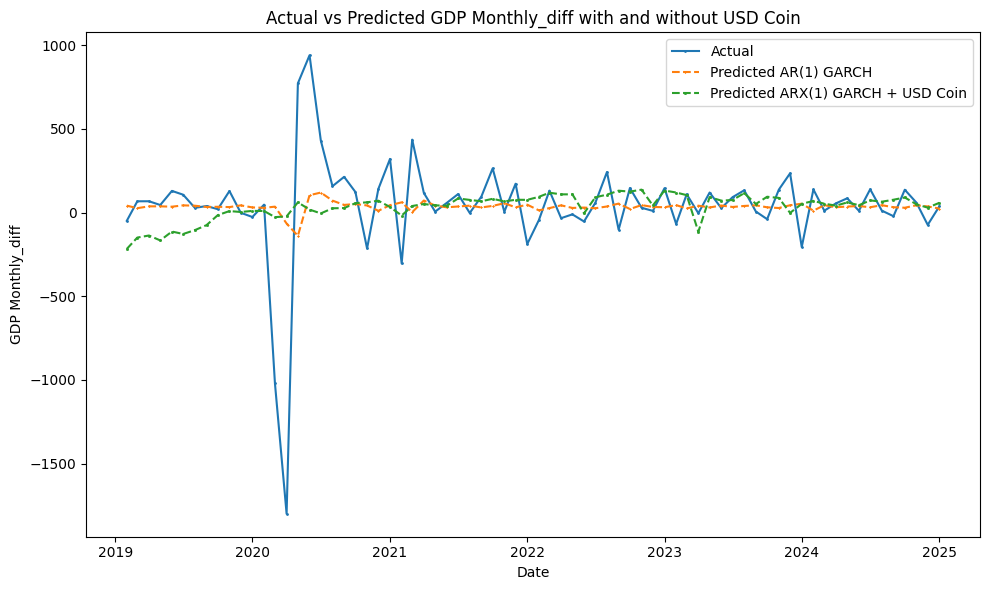

Model Comparison Metrics:
Metric     | AR(1)        | ARX + USD Coin 
----------------------------------------
R²         | 0.0254       | -0.0001        
MSE        | 94593.6220   | 97075.6933     


In [29]:
# replace this with pairs as needed
# plot_actual_vs_predicted(df, 'GDP Monthly', 'USD coin', res)
plot_actual_vs_predicted_with_baseline(df, 'GDP Monthly', 'USD Coin', res)

## Metrics table, just (1,1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

metrics = []

# Filter only successful models with valid exogenous terms
for row in results_df.dropna(subset=['Coef']).itertuples():
    macro = row.Macro
    macro_col = row.Macro_col
    asset = row.Crypto

    df_temp = df[[macro_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        continue

    # Standardize
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[macro_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    try:
        # Refit AR(1)
        model_ar = arch_model(y_scaled, mean='AR', lags=1, vol='GARCH', p=1, q=1, dist='normal')
        res_ar = model_ar.fit(disp='off')
        pred_ar_scaled = res_ar.params['Const'] + res_ar.params['y[1]'] * y_scaled[:-1]
        y_actual_ar_scaled = y_scaled[1:]
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
        y_actual_ar = scaler_y.inverse_transform(y_actual_ar_scaled.reshape(-1, 1)).flatten()

        # Refit ARX(1)
        model_arx = arch_model(y_scaled, mean='ARX', lags=1, vol='GARCH', p=1, q=1, x=x_scaled, dist='normal')
        res_arx = model_arx.fit(disp='off')
        pred_arx_scaled = (
            res_arx.params['Const']
            + res_arx.params['y[1]'] * y_scaled[:-1]
            + res_arx.params.get('x0', 0) * x_scaled[1:]
        )
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual_arx = scaler_y.inverse_transform(y_scaled[1:].reshape(-1, 1)).flatten()

        # Metrics
        metrics.append({
            'Macro': macro,
            'Crypto': asset,
            'MSE_AR': mean_squared_error(y_actual_ar, pred_ar),
            'MSE_ARX': mean_squared_error(y_actual_arx, pred_arx),
            'RMSE_AR': np.sqrt(mean_squared_error(y_actual_ar, pred_ar)),
            'RMSE_ARX': np.sqrt(mean_squared_error(y_actual_arx, pred_arx)),
            'R2_AR': r2_score(y_actual_ar, pred_ar),
            'R2_ARX': r2_score(y_actual_arx, pred_arx),
            'MAPE_AR': mean_absolute_percentage_error(y_actual_ar, pred_ar),
            'MAPE_ARX': mean_absolute_percentage_error(y_actual_arx, pred_arx),
            'MSE_Diff': mean_squared_error(y_actual_ar, pred_ar) - mean_squared_error(y_actual_arx, pred_arx)
        })

    except Exception as e:
        print(f"Skipping {macro}-{asset} in metrics due to error: {e}")

# Build and show
metrics_df = pd.DataFrame(metrics)

# Optional: sort by improvement (e.g. MSE reduction)
metrics_df_sorted = metrics_df.sort_values(by='MSE_Diff', ascending=False)

# Show key results
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(metrics_df_sorted)


,Macro,Crypto,MSE_AR,MSE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX,MAPE_AR,MAPE_ARX,MSE_Diff
31,M1,Ethereum,1.460706e+06,1.436622e+06,1208.596676,1198.591702,5.518570e-03,0.021915,2.971877e+00,3.699164e+00,2.408386e+04
27,M1,Bitcoin,1.460706e+06,1.444666e+06,1208.596676,1201.942408,5.518570e-03,0.016439,2.971877e+00,3.238448e+00,1.604037e+04
33,M1,Cardano,1.531100e+06,1.522934e+06,1237.376453,1234.071946,4.314768e-03,0.009626,2.503714e+00,3.573243e+00,8.166919e+03
35,M1,Bitcoin Price,1.460706e+06,1.452971e+06,1208.596676,1205.392484,5.518570e-03,0.010785,2.971877e+00,3.681695e+00,7.734883e+03
34,M1,USD Coin,1.757573e+06,1.752149e+06,1325.734761,1323.687839,5.354176e-03,0.008423,3.619995e+00,4.151916e+00,5.423162e+03
32,M1,Dogecoin,1.460706e+06,1.457668e+06,1208.596676,1207.339219,5.518570e-03,0.007587,2.971877e+00,3.158974e+00,3.037936e+03
79,GDP Monthly,USD Coin,9.459362e+04,9.326442e+04,307.560762,305.392232,2.543556e-02,0.039130,2.603927e+00,2.405634e+00,1.329207e+03
36,IM,Bitcoin,1.168450e+04,1.092137e+04,108.094863,104.505340,-7.693569e-04,0.064592,5.221209e+16,6.639915e+16,7.631332e+02
44,IM,Bitcoin Price,1.168450e+04,1.094001e+04,108.094863,104.594496,-7.693569e-04,0.062996,5.221209e+16,8.714469e+16,7.444906e+02
28,M1,Tether,1.460706e+06,1.459976e+06,1208.596676,1208.294488,5.518570e-03,0.006016,2.971877e+00,3.195776e+00,7.303562e+02


## Test & Train

Evaluation on Test Set (GDP Monthly-USD Coin):
p = 1, q = 1
R²: -0.0528
MSE: 11017.2447
RMSE: 104.9631
MAPE: 1.0853


/Users/tianyishen/Desktop/CSUREMM project/CryptoMacroecon-Prediction-CSUREMM-1/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/tianyishen/Desktop/CSUREMM project/CryptoMacroecon-Prediction-CSUREMM-1/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


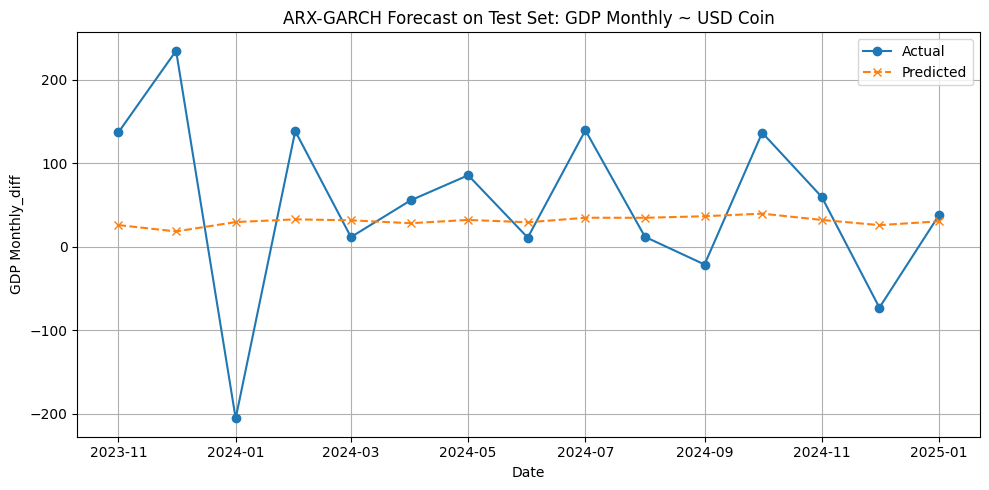

In [30]:
def evaluate_arx_garch_train_test(df, macro, asset, test_size=0.2, max_pq=3):
    # Use differenced macro if present
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 50:
        print(f"Not enough data for {macro}-{asset}")
        return

    # Train-test split
    split_idx = int(len(df_temp) * (1 - test_size))
    df_train = df_temp.iloc[:split_idx]
    df_test = df_temp.iloc[split_idx:]

    # Scale data
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()

    # Grid search for best (p, q) on training set
    best_aic = np.inf
    best_model = None
    best_pq = (1, 1)

    for p in range(1, max_pq + 1):
        for q in range(1, max_pq + 1):
            try:
                model = arch_model(
                    y_train_scaled,
                    mean='ARX',
                    lags=1,
                    vol='GARCH',
                    p=p,
                    q=q,
                    x=x_train_scaled,
                    dist='normal'
                )
                res = model.fit(disp='off')
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_model = res
                    best_pq = (p, q)
            except:
                continue

    if best_model is None:
        print(f"Model fitting failed for {macro}-{asset}")
        return

    # Forecasting
    y_test = df_test[[y_col]].values.flatten()
    x_test = df_test[[asset]].values.flatten()

    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    x_test_scaled = scaler_x.transform(x_test.reshape(-1, 1)).flatten()

    y_train_last = y_train_scaled[-1]
    preds_scaled = []
    for t in range(len(y_test_scaled)):
        y_lag = preds_scaled[-1] if preds_scaled else y_train_last
        x_now = x_test_scaled[t]
        pred = (
            best_model.params['Const']
            + best_model.params['y[1]'] * y_lag
            + best_model.params.get('x0', 0) * x_now
        )
        preds_scaled.append(pred)

    preds_scaled = np.array(preds_scaled)
    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
    y_actual = df_test[y_col].values

    # Metrics
    r2 = r2_score(y_actual, preds)
    mse = mean_squared_error(y_actual, preds)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_actual, preds)

    print(f"Evaluation on Test Set ({macro}-{asset}):")
    print(f"p = {best_pq[0]}, q = {best_pq[1]}")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df_test.index, y_actual, label='Actual', marker='o')
    plt.plot(df_test.index, preds, label='Predicted', linestyle='--', marker='x')
    plt.title(f'ARX-GARCH Forecast on Test Set: {macro} ~ {asset}')
    plt.xlabel('Date')
    plt.ylabel(y_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

evaluate_arx_garch_train_test(df, macro='GDP Monthly', asset='USD Coin', test_size=0.2)


## New Code for adjusting p, q for each pair

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

results = []

for macro in macro_list:
    if f'{macro}_diff_diff' in df.columns:
        y_col = f'{macro}_diff_diff'
    elif f'{macro}_diff' in df.columns:
        y_col = f'{macro}_diff'
    else:
        y_col = macro

    for asset in asset_list:
        df_temp = df[[y_col, asset]].dropna().copy()
        if len(df_temp) < 30:
            print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
            continue

        y_var = df_temp[y_col].var()
        x_var = df_temp[asset].var()
        if y_var == 0 or x_var == 0:
            print(f"Skipping {macro}-{asset}: zero variance in y or x")
            continue

        scaler_y = StandardScaler()
        scaler_x = StandardScaler()
        y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
        x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

        best_aic = np.inf
        best_res = None
        best_pq = (1, 1)

        # Try multiple (p,q)
        for p in range(1, 6):
            for q in range(1, 6):
                try:
                    model = arch_model(
                        y_scaled,
                        mean='ARX',
                        lags=1,
                        vol='GARCH',
                        p=p,
                        q=q,
                        x=x_scaled,
                        dist='normal'
                    )
                    res = model.fit(disp='off')
                    if res.aic < best_aic:
                        best_aic = res.aic
                        best_res = res
                        best_pq = (p, q)
                except:
                    continue

        if best_res is not None:
            # Reconstruct predictions for ARX
            y_lag = y_scaled[:-1]
            x_current = x_scaled[1:]
            y_actual_scaled = y_scaled[1:]

            pred_arx_scaled = (
                best_res.params['Const']
                + best_res.params['y[1]'] * y_lag
                + best_res.params.get('x0', 0) * x_current
            )

            pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
            y_actual_arx = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

            # Fit AR-only model
            try:
                ar_model = arch_model(y_scaled, mean='AR', lags=1, vol='GARCH', p=best_pq[0], q=best_pq[1], dist='normal')
                ar_res = ar_model.fit(disp='off')
                pred_ar_scaled = ar_res.params['Const'] + ar_res.params['y[1]'] * y_scaled[:-1]
                pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
                y_actual_ar = y_actual_arx  # same target values as ARX

                # Metrics
                mse_ar = mean_squared_error(y_actual_ar, pred_ar)
                mse_arx = mean_squared_error(y_actual_arx, pred_arx)
                rmse_ar = np.sqrt(mse_ar)
                rmse_arx = np.sqrt(mse_arx)
                r2_ar = r2_score(y_actual_ar, pred_ar)
                r2_arx = r2_score(y_actual_arx, pred_arx)
                mape_ar = mean_absolute_percentage_error(y_actual_ar, pred_ar)
                mape_arx = mean_absolute_percentage_error(y_actual_arx, pred_arx)

                exog_params = [p for p in best_res.params.index if p.startswith('x')]
                coef = best_res.params[exog_params[0]] if exog_params else np.nan
                pval = best_res.pvalues[exog_params[0]] if exog_params else np.nan

                results.append({
                    'Macro': macro,
                    'Macro_col': y_col,
                    'Crypto': asset,
                    'Param': exog_params[0] if exog_params else None,
                    'Coef': coef,
                    'P-value': pval,
                    'AIC': best_res.aic,
                    'BIC': best_res.bic,
                    'p': best_pq[0],
                    'q': best_pq[1],
                    'MSE_AR': mse_ar,
                    'MSE_ARX': mse_arx,
                    'RMSE_AR': rmse_ar,
                    'RMSE_ARX': rmse_arx,
                    'R2_AR': r2_ar,
                    'R2_ARX': r2_arx,
                    'MAPE_AR': mape_ar,
                    'MAPE_ARX': mape_arx,
                    'MSE_Diff': mse_ar - mse_arx,
                    'Model_Success': True
                })
            except Exception as e:
                print(f"AR-only model failed for {macro}-{asset}: {e}")
                continue
        else:
            print(f"Error fitting model for {macro}-{asset}: No valid model found")
            results.append({
                'Macro': macro,
                'Macro_col': y_col,
                'Crypto': asset,
                'Param': None,
                'Coef': np.nan,
                'P-value': np.nan,
                'AIC': np.nan,
                'BIC': np.nan,
                'p': np.nan,
                'q': np.nan,
                'MSE_AR': np.nan,
                'MSE_ARX': np.nan,
                'RMSE_AR': np.nan,
                'RMSE_ARX': np.nan,
                'R2_AR': np.nan,
                'R2_ARX': np.nan,
                'MAPE_AR': np.nan,
                'MAPE_ARX': np.nan,
                'MSE_Diff': np.nan,
                'Model_Success': False
            })

# Build and show
results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(results_df.sort_values(by='P-value', na_position='last'))


/Users/tianyishen/Desktop/CSUREMM project/CryptoMacroecon-Prediction-CSUREMM-1/.venv/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/tianyishen/Desktop/CSUREMM project/CryptoMacroecon-Prediction-CSUREMM-1/.venv/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/tianyishen/Desktop/CSUREMM project/CryptoMacroecon-Prediction-CSUREMM-1/.venv/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/tianyishen/Desktop/CSURE

,Macro,Macro_col,Crypto,Param,Coef,P-value,AIC,BIC,p,q,MSE_AR,MSE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX,MAPE_AR,MAPE_ARX,MSE_Diff,Model_Success
36,IM,IM_diff,Bitcoin,x0,0.002680,2.875647e-10,-39.975321,-10.384424,4,4,1.192242e+04,1.199755e+04,109.189857,109.533319,-0.021148,-0.027582,4.976978e+15,1.857253e+15,-7.512306e+01,True
42,IM,IM_diff,Cardano,x0,-0.011622,1.439928e-07,-84.382532,-60.194126,3,3,1.251386e+04,1.251600e+04,111.865355,111.874914,-0.025215,-0.025390,5.700799e+14,3.686324e+15,-2.138896e+00,True
143,vol_EX,vol_EX_diff,Bitcoin Price,x0,0.031351,8.827319e-07,33.357056,58.995122,4,3,1.136565e-04,1.148820e-04,0.010661,0.010718,-0.000003,-0.010785,2.613109e+10,9.203840e+11,-1.225461e-06,True
131,vol_IM,vol_IM_diff_diff,Dogecoin,x0,-0.239480,3.361846e-05,139.941855,153.846784,1,1,1.057377e-04,1.143069e-04,0.010283,0.010691,0.251874,0.191245,5.524129e+12,6.160014e+12,-8.569116e-06,True
77,GDP Monthly,GDP Monthly_diff,Dogecoin,x0,-0.187907,6.594698e-04,136.076983,150.872432,1,1,7.913196e+04,8.601397e+04,281.304030,293.281390,0.020827,-0.064331,2.449222e+00,2.038479e+00,-6.882016e+03,True
140,vol_EX,vol_EX_diff,Dogecoin,x0,-0.015800,1.281637e-03,-10.681655,12.625679,3,3,1.146660e-04,1.132209e-04,0.010708,0.010641,-0.008886,0.003830,1.355061e+12,6.776626e+11,1.445173e-06,True
49,EX,EX_diff,Ethereum,x0,0.003488,1.984397e-03,-46.213002,-21.553921,3,3,7.484803e+03,7.410051e+03,86.514753,86.081652,-0.023922,-0.013696,1.196126e+16,1.535881e+15,7.475175e+01,True
104,vol_r,vol_r_diff,Dogecoin,x0,0.179359,2.642710e-03,140.457847,163.765181,1,5,9.062481e-03,1.499424e-02,0.095197,0.122451,0.014372,-0.630760,2.192357e+12,6.271758e+12,-5.931755e-03,True
102,vol_r,vol_r_diff,XRP,x0,0.044702,2.688224e-03,168.342414,193.980481,2,5,1.538169e-02,1.540974e-02,0.124023,0.124136,-0.672900,-0.675950,1.958637e+12,3.074858e+12,-2.804603e-05,True
86,vol_LFPR,vol_LFPR_diff,Dogecoin,x0,0.096487,2.980776e-03,116.488218,139.795551,1,5,3.372833e-06,3.448593e-06,0.001837,0.001857,-0.672418,-0.709984,5.320935e+10,7.790243e+10,-7.576021e-08,True


In [ ]:
# Filter to only models where ARX improves over AR
results_df_filtered = results_df[
    (results_df['Model_Success']) &
    (results_df['R2_ARX'] > results_df['R2_AR'])
]

# Sort by best R² from ARX (crypto-enhanced model)
results_df_sorted = results_df_filtered.sort_values(by='R2_ARX', ascending=False)

# Display sorted results
display(results_df_sorted)


,Macro,Macro_col,Crypto,Param,Coef,P-value,AIC,BIC,p,q,MSE_AR,MSE_ARX,RMSE_AR,RMSE_ARX,R2_AR,R2_ARX,MAPE_AR,MAPE_ARX,MSE_Diff,Model_Success
132,vol_IM,vol_IM_diff_diff,Cardano,x0,-0.114261,0.416006,185.898796,199.803724,1,1,1.057377e-04,1.013897e-04,0.010283,0.010069,0.251874,0.282638,5.524129e+12,5.203065e+12,4.348013e-06,True
126,vol_IM,vol_IM_diff_diff,Bitcoin,x0,-0.134531,0.165075,185.255734,199.160662,1,1,1.057377e-04,1.021096e-04,0.010283,0.010105,0.251874,0.277545,5.524129e+12,5.943217e+12,3.628173e-06,True
128,vol_IM,vol_IM_diff_diff,Litecoin,x0,-0.056815,0.650339,187.107392,201.012320,1,1,1.057377e-04,1.035588e-04,0.010283,0.010176,0.251874,0.267291,5.524129e+12,5.184078e+12,2.178918e-06,True
130,vol_IM,vol_IM_diff_diff,Ethereum,x0,-0.028400,0.833476,187.390785,201.295714,1,1,1.057377e-04,1.046907e-04,0.010283,0.010232,0.251874,0.259283,5.524129e+12,5.362028e+12,1.047094e-06,True
129,vol_IM,vol_IM_diff_diff,XRP,x0,-0.045248,0.755131,187.266330,201.171258,1,1,1.057377e-04,1.051636e-04,0.010283,0.010255,0.251874,0.255937,5.524129e+12,5.477731e+12,5.741973e-07,True
124,vol_GDP,vol_GDP_diff,USD Coin,x0,0.010056,0.938197,147.795279,168.285274,1,4,8.873397e-06,8.868316e-06,0.002979,0.002978,0.201361,0.201819,3.776439e+00,3.651109e+00,5.081600e-09,True
123,vol_GDP,vol_GDP_diff,Cardano,x0,-0.045403,0.830643,161.817136,175.801536,1,1,8.579822e-06,8.447673e-06,0.002929,0.002906,0.185341,0.197888,6.400636e+00,7.617059e+00,1.321494e-07,True
117,vol_GDP,vol_GDP_diff,Bitcoin,x0,-0.025964,0.910903,162.356367,176.340767,1,1,8.579822e-06,8.511762e-06,0.002929,0.002917,0.185341,0.191803,6.400636e+00,6.606723e+00,6.806019e-08,True
125,vol_GDP,vol_GDP_diff,Bitcoin Price,x0,-0.168969,0.422285,143.477552,157.461952,1,1,8.579822e-06,8.542457e-06,0.002929,0.002923,0.185341,0.188888,6.400636e+00,1.000153e+01,3.736491e-08,True
119,vol_GDP,vol_GDP_diff,Litecoin,x0,-0.000255,0.999468,162.702161,176.686561,1,1,8.579822e-06,8.579308e-06,0.002929,0.002929,0.185341,0.185389,6.400636e+00,6.401481e+00,5.148704e-10,True


In [32]:
def plot_garch_mean_predictions(df, macro, asset, y_col, p, q, title_suffix=""):
    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 2:
        print(f"Skipping {macro}-{asset}: not enough data to plot")
        return

    # Standardize
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_scaled = scaler_y.fit_transform(df_temp[[y_col]]).flatten()
    x_scaled = scaler_x.fit_transform(df_temp[[asset]]).flatten()

    # Align for 1-lag
    y_lag = y_scaled[:-1]
    x_current = x_scaled[1:]
    y_actual_scaled = y_scaled[1:]
    y_index = df_temp.index[1:]

    try:
        # === ARX (GARCH-X)
        model = arch_model(
            y_scaled,
            mean='ARX',
            lags=1,
            vol='GARCH',
            p=int(p), q=int(q),
            x=x_scaled,
            dist='normal'
        )
        res = model.fit(disp='off')

        pred_arx_scaled = (
            res.params['Const']
            + res.params['y[1]'] * y_lag
            + res.params.get('x0', 0) * x_current
        )
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).flatten()

        # === AR-only
        model_ar = arch_model(
            y_scaled,
            mean='AR',
            lags=1,
            vol='GARCH',
            p=int(p), q=int(q),
            dist='normal'
        )
        res_ar = model_ar.fit(disp='off')
        pred_ar_scaled = res_ar.params['Const'] + res_ar.params['y[1]'] * y_lag
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()

        # === Plot
        plt.figure(figsize=(10, 5))
        plt.plot(y_index, y_actual, label='Actual', color='black', marker='o')
        plt.plot(y_index, pred_ar, label='AR Prediction', linestyle='--', marker='x')
        plt.plot(y_index, pred_arx, label='ARX Prediction', linestyle='--', marker='s')
        plt.title(f'{macro}-{asset} GARCH Mean Forecasts {title_suffix}')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting failed for {macro}-{asset}: {e}")

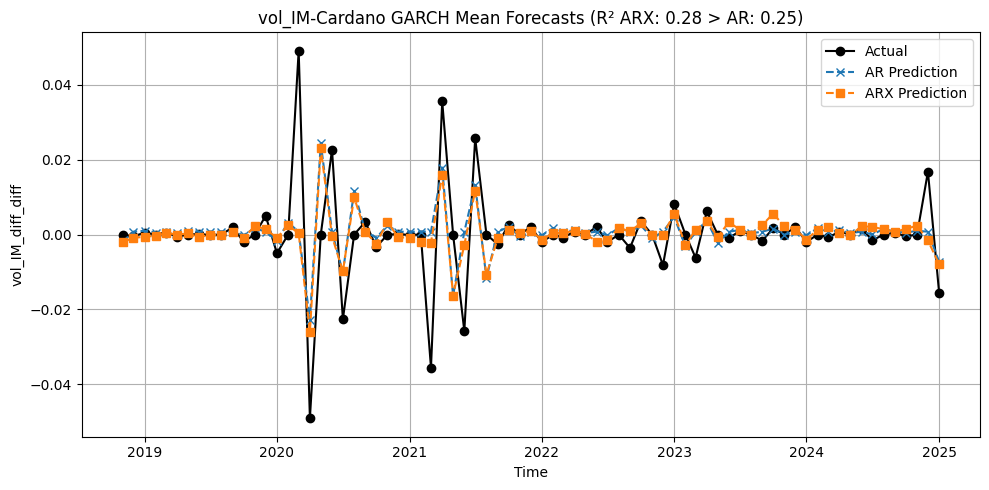

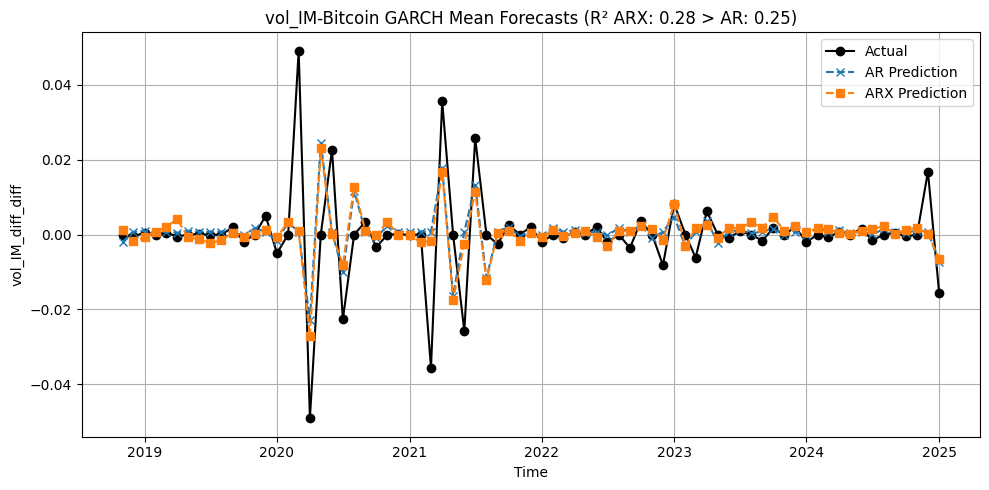

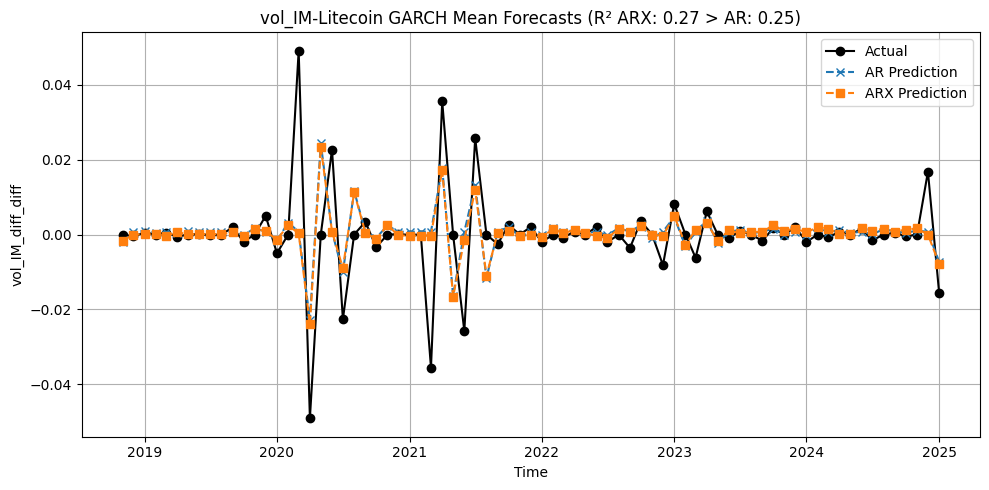

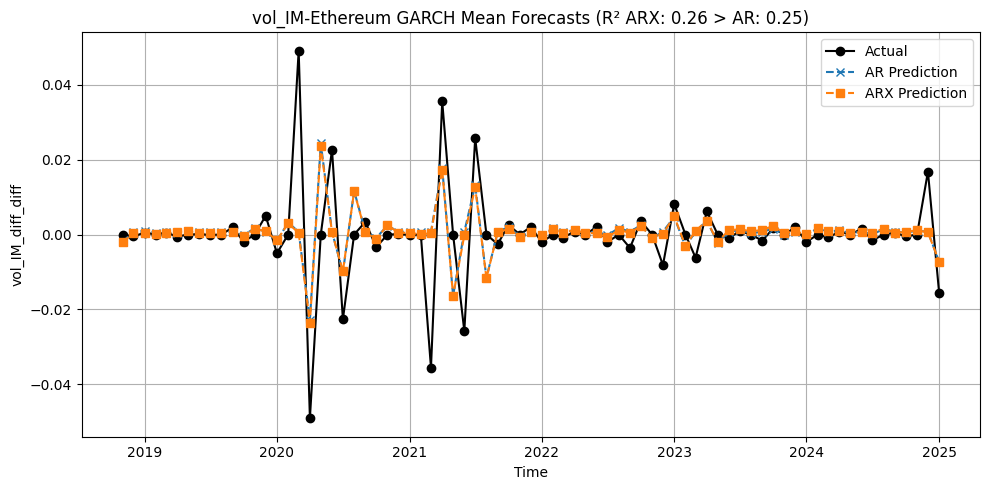

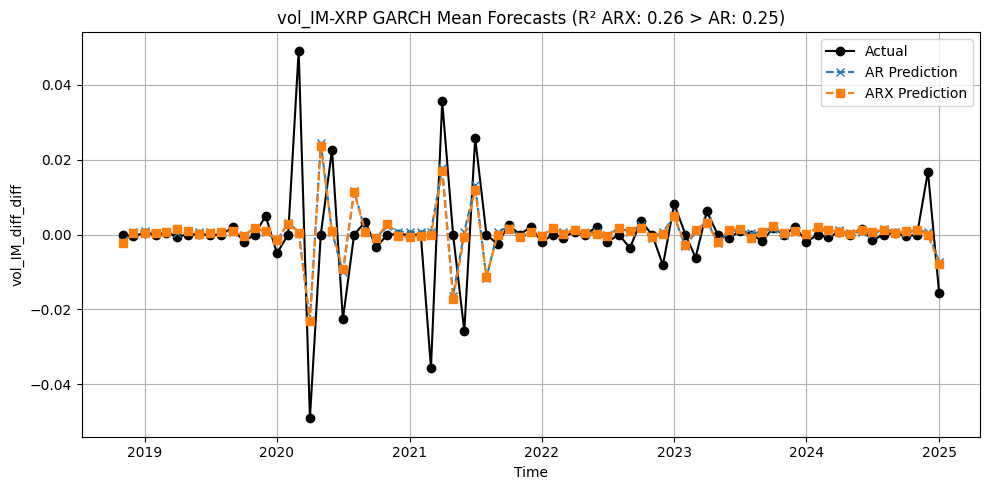

In [33]:
for _, row in results_df_sorted.head(5).iterrows():  # Adjust head(N) as needed
    macro = row['Macro']
    asset = row['Crypto']
    y_col = row['Macro_col']
    p = row['p']
    q = row['q']

    plot_garch_mean_predictions(df, macro, asset, y_col, p, q,
        title_suffix=f"(R² ARX: {row['R2_ARX']:.2f} > AR: {row['R2_AR']:.2f})")


## With test & train- flat bcus using constant-mean forecasts?

In [61]:
def plot_garch_mean_predictions_split(df, macro, asset, y_col, p, q, title_suffix=""):
    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
        return

    train_size = int(len(df_temp) * 0.64)
    df_train = df_temp.iloc[:train_size]
    df_test = df_temp.iloc[train_size:]

    # Scale separately to prevent data leakage
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()

    y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
    x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

    try:
        # === ARX model on training
        model = arch_model(
            y_train_scaled,
            mean='ARX',
            lags=1,
            vol='GARCH',
            p=int(p), q=int(q),
            x=x_train_scaled,
            dist='normal'
        )
        res = model.fit(disp='off')

        # Forecast mean over test
        pred_arx_scaled = res.params['Const'] + \
                          res.params['y[1]'] * y_train_scaled[-1] + \
                          res.params.get('x0', 0) * x_test_scaled
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
        index_test = df_test.index

        # === AR model on training
        model_ar = arch_model(
            y_train_scaled,
            mean='AR',
            lags=1,
            vol='GARCH',
            p=int(p), q=int(q),
            dist='normal'
        )
        res_ar = model_ar.fit(disp='off')

        # Use .forecast() to get dynamic mean forecasts for the test horizon
        forecasts_ar = res_ar.forecast(horizon=len(y_test_scaled), method='analytic')
        # forecasts_ar.mean is shape (1, horizon)
        pred_ar_scaled = forecasts_ar.mean.values[-1, :]
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()

        # === Plot
        plt.figure(figsize=(10, 5))
        plt.plot(index_test, y_actual, label='Actual (Test)', color='black', marker='o')
        plt.plot(index_test, pred_ar, label='AR Forecast', linestyle='--', marker='x')
        plt.plot(index_test, pred_arx, label='ARX Forecast', linestyle='--', marker='s')
        plt.title(f'{macro}-{asset} GARCH Mean Forecasts (Test Only) {title_suffix}')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting failed for {macro}-{asset}: {e}")


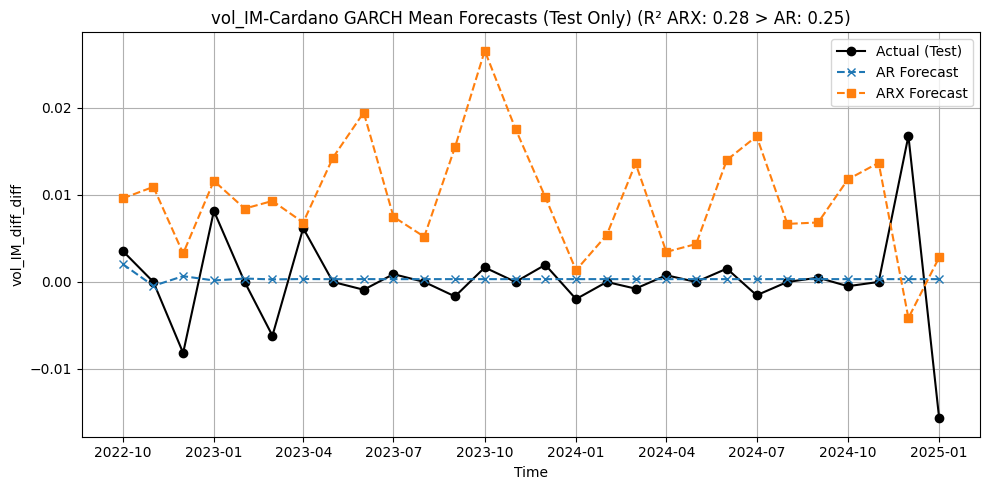

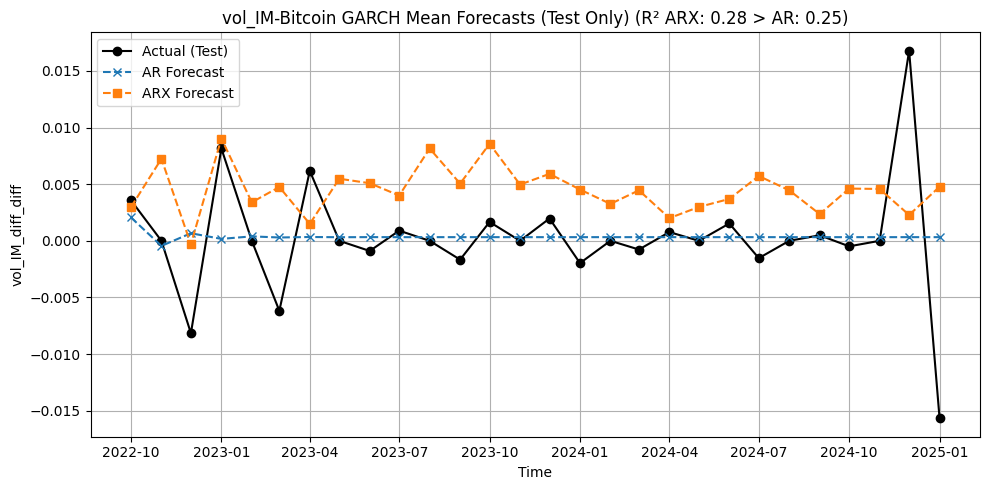

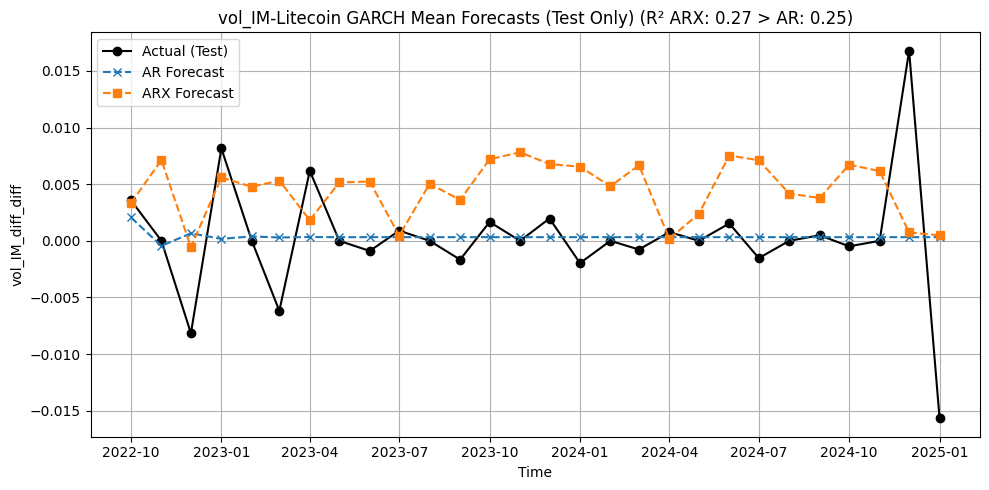

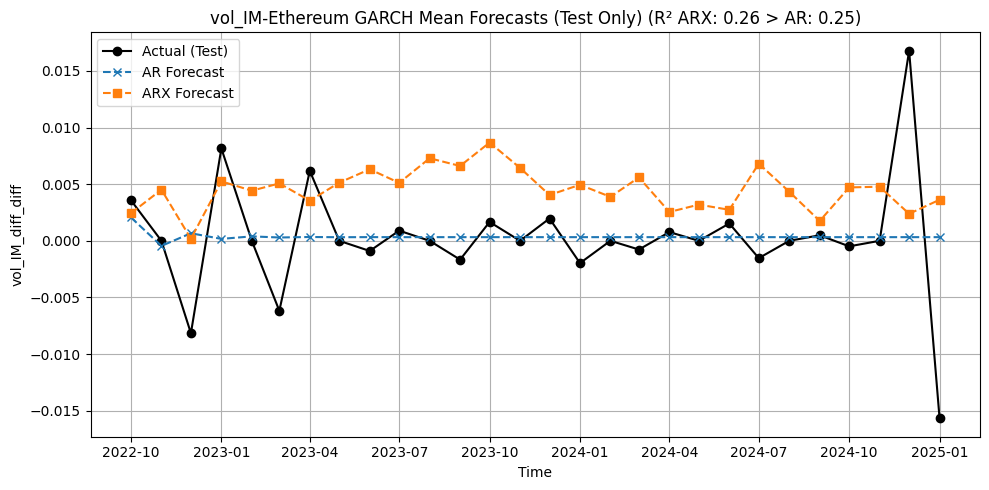

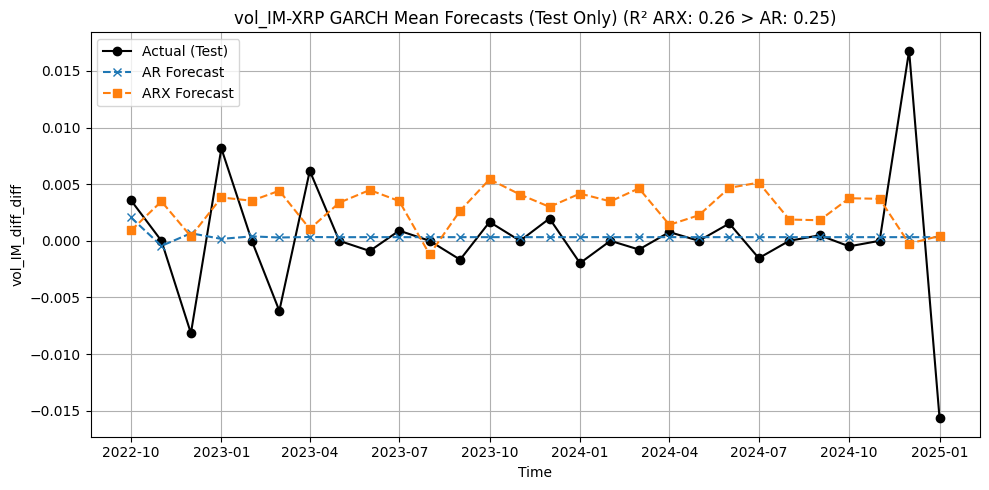

In [62]:
for _, row in results_df_sorted.head(5).iterrows():
    macro = row['Macro']
    asset = row['Crypto']
    y_col = row['Macro_col']
    p = row['p']
    q = row['q']

    plot_garch_mean_predictions_split(df, macro, asset, y_col, p, q,
        title_suffix=f"(R² ARX: {row['R2_ARX']:.2f} > AR: {row['R2_AR']:.2f})")


In [64]:

def rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q):
    history = list(y_train_scaled)
    preds = []

    for t in range(len(y_test_scaled)):
        model = arch_model(history, mean='AR', lags=1, vol='GARCH', p=p, q=q, dist='normal')
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1, method='analytic')
        pred = forecast.mean.values[-1, 0]
        preds.append(pred)
        history.append(y_test_scaled[t])  # Add actual value for next iteration

    return np.array(preds)

def rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q):
    history_y = list(y_train_scaled)
    history_x = list(x_train_scaled)
    preds = []

    for t in range(len(y_test_scaled)):
        x_arr = np.array(history_x)
        model = arch_model(history_y, mean='ARX', lags=1, vol='GARCH', p=p, q=q, x=x_arr, dist='normal')
        res = model.fit(disp='off')

        # Mean forecast = Const + phi * y_t + beta * x_{t+1}
        const = res.params.get('Const', 0)
        phi = res.params.get('y[1]', 0)
        beta = res.params.get('x0', 0)

        y_t = history_y[-1]
        x_t1 = x_test_scaled[t]

        pred = const + phi * y_t + beta * x_t1
        preds.append(pred)

        # Update histories with actuals for next step
        history_y.append(y_test_scaled[t])
        history_x.append(x_test_scaled[t])

    return np.array(preds)

def plot_garch_mean_predictions_rolling(df, macro, asset, y_col, p, q, title_suffix=""):
    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
        return

    train_size = int(len(df_temp) * 0.7)
    df_train = df_temp.iloc[:train_size]
    df_test = df_temp.iloc[train_size:]

    # Scale separately to avoid leakage
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
    y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
    x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

    try:
        # Rolling forecasts
        pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, int(p), int(q))
        pred_arx_scaled = rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, int(p), int(q))

        # Inverse scale
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
        index_test = df_test.index

        # Plot results
        plt.figure(figsize=(10, 5))
        plt.plot(index_test, y_actual, label='Actual (Test)', color='black', marker='o')
        plt.plot(index_test, pred_ar, label='AR Forecast (Rolling)', linestyle='--', marker='x')
        plt.plot(index_test, pred_arx, label='ARX Forecast (Rolling)', linestyle='--', marker='s')
        plt.title(f'{macro}-{asset} GARCH Mean Rolling Forecasts {title_suffix}')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting failed for {macro}-{asset}: {e}")


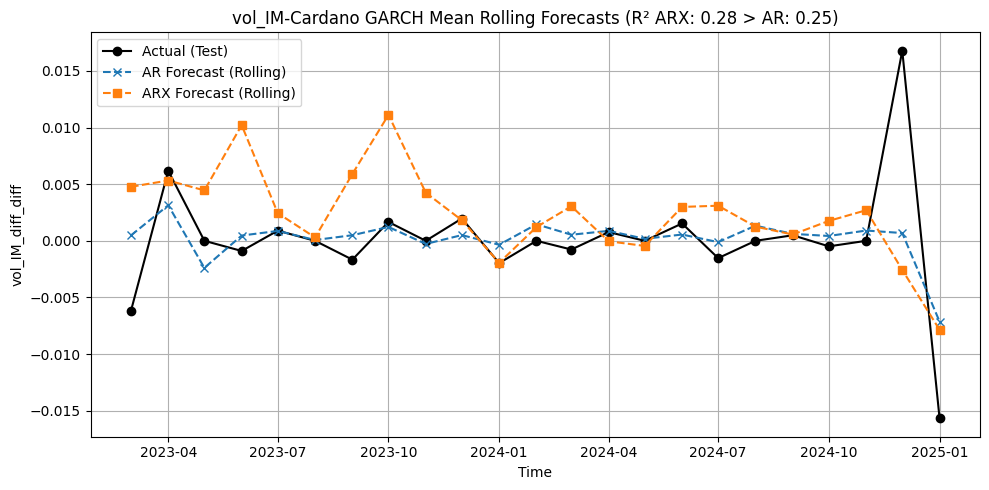

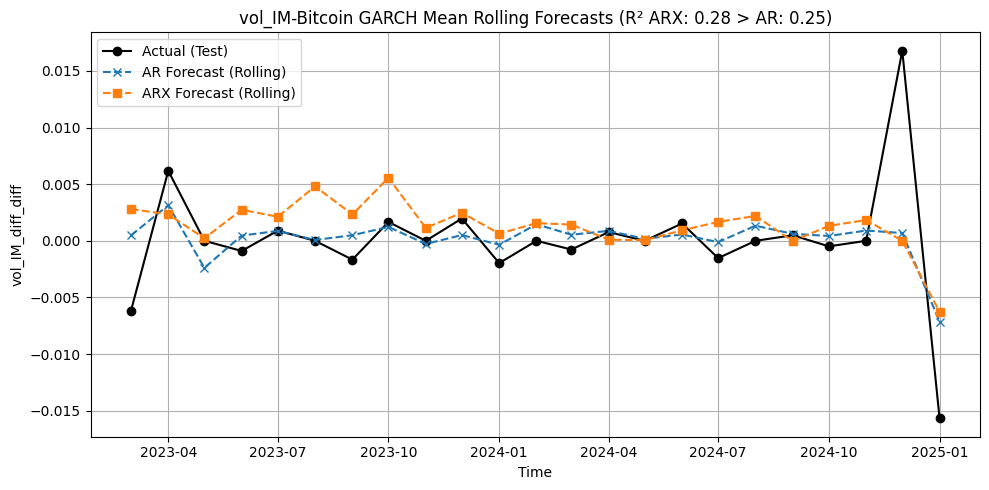

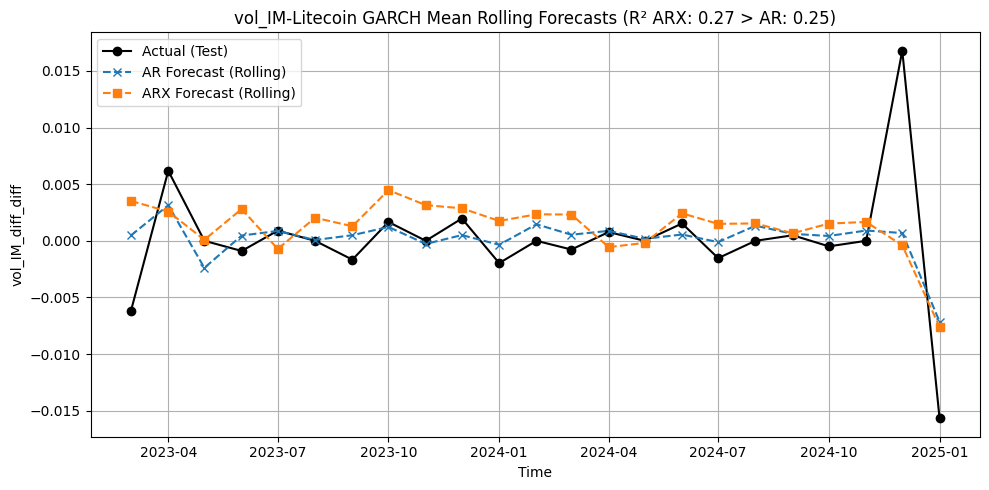

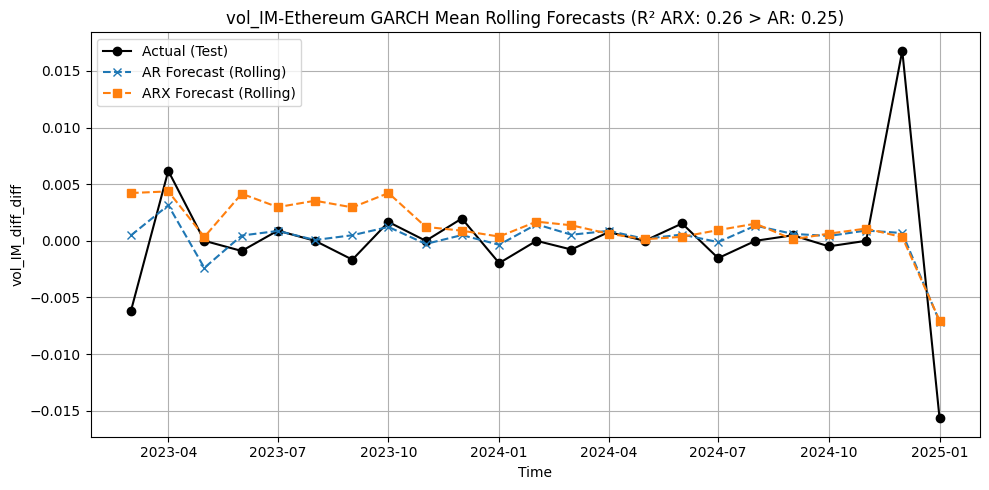

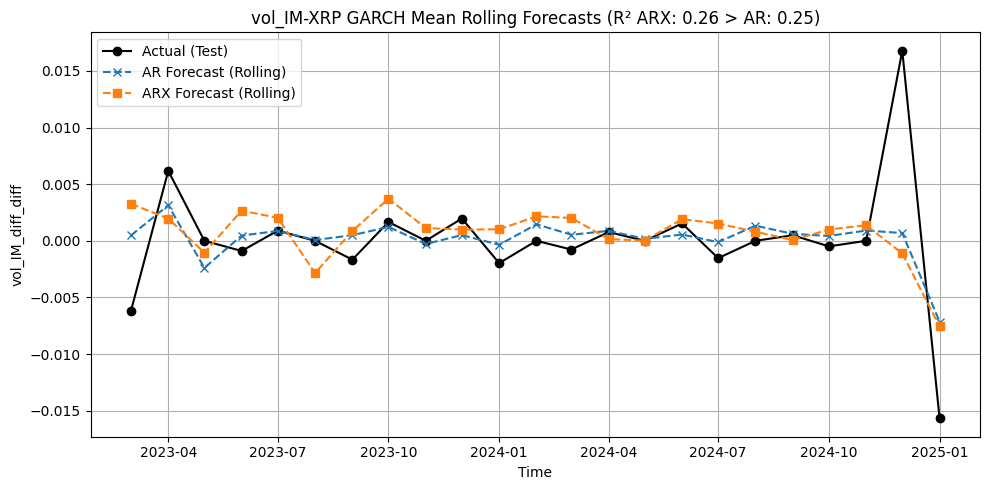

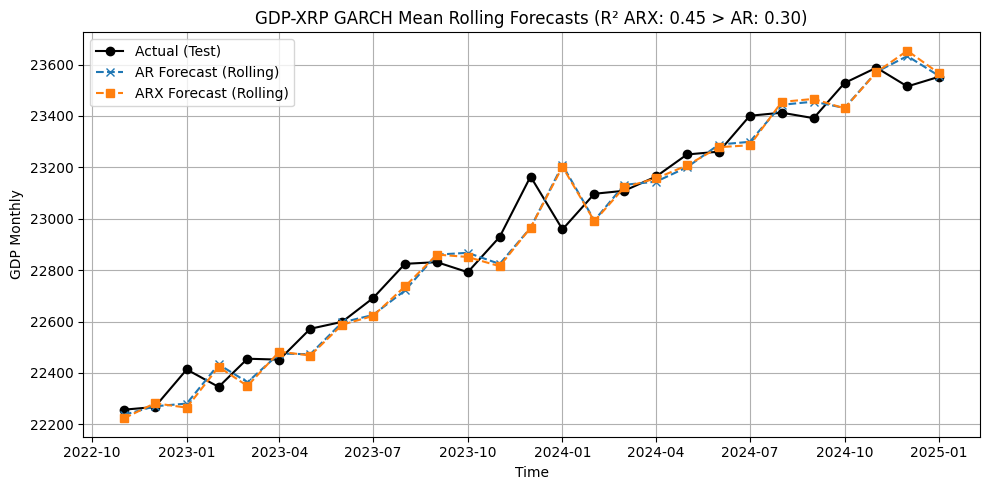

In [71]:
for _, row in results_df_sorted.head(5).iterrows():
    macro = row['Macro']
    asset = row['Crypto']
    y_col = row['Macro_col']
    p = row['p']
    q = row['q']

    plot_garch_mean_predictions_rolling(df, macro, asset, y_col, p, q,
        title_suffix=f"(R² ARX: {row['R2_ARX']:.2f} > AR: {row['R2_AR']:.2f})")

plot_garch_mean_predictions_rolling(df, 'GDP', 'XRP', 'GDP Monthly', 1, 1, title_suffix='(R² ARX: 0.45 > AR: 0.30)')


## Generating MAPE with this new rolling method

MAPE AR: 0.31%, ARX: 0.33%, ARX improvement: -3.83%


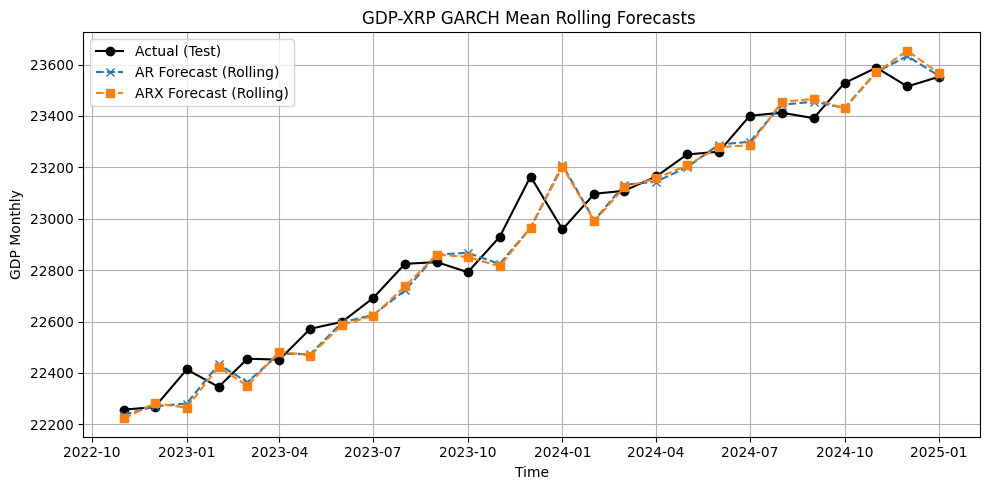

MAPE AR: 172.05%, ARX: 160.62%, ARX improvement: 6.64%


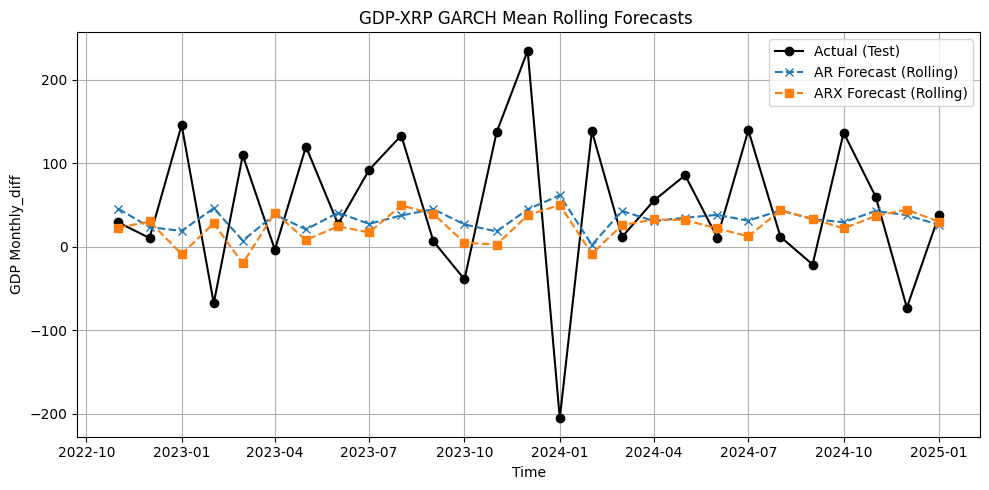

In [89]:
def plot_garch_mean_predictions_rolling(df, macro, asset, y_col, p, q, title_suffix=""):
    df_temp = df[[y_col, asset]].dropna().copy()
    if len(df_temp) < 30:
        print(f"Skipping {macro}-{asset}: insufficient data ({len(df_temp)})")
        return

    train_size = int(len(df_temp) * 0.7)
    df_train = df_temp.iloc[:train_size]
    df_test = df_temp.iloc[train_size:]

    # Scale separately to avoid leakage
    scaler_y = StandardScaler()
    scaler_x = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
    x_train_scaled = scaler_x.fit_transform(df_train[[asset]]).flatten()
    y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
    x_test_scaled = scaler_x.transform(df_test[[asset]]).flatten()

    try:
        # Rolling forecasts
        pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, int(p), int(q))
        pred_arx_scaled = rolling_forecast_arx(
            y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, int(p), int(q)
        )

        # Inverse scale
        pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
        pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
        y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
        index_test = df_test.index

        # ✅ Compute MAPE values
        def safe_mape(actual, predicted):
            actual, predicted = np.array(actual), np.array(predicted)
            mask = actual != 0
            return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100 if np.any(mask) else np.nan

        mape_ar = safe_mape(y_actual, pred_ar)
        mape_arx = safe_mape(y_actual, pred_arx)
        mape_change = ((mape_ar - mape_arx) / mape_ar) * 100 if mape_ar != 0 else np.nan

        print(f"MAPE AR: {mape_ar:.2f}%, ARX: {mape_arx:.2f}%, ARX improvement: {mape_change:.2f}%")

        # Plot results
        plt.figure(figsize=(10, 5))
        plt.plot(index_test, y_actual, label='Actual (Test)', color='black', marker='o')
        plt.plot(index_test, pred_ar, label='AR Forecast (Rolling)', linestyle='--', marker='x')
        plt.plot(index_test, pred_arx, label='ARX Forecast (Rolling)', linestyle='--', marker='s')
        plt.title(f'{macro}-{asset} GARCH Mean Rolling Forecasts {title_suffix}')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting failed for {macro}-{asset}: {e}")

plot_garch_mean_predictions_rolling(df, 'GDP', 'XRP', 'GDP Monthly', 1, 1)
plot_garch_mean_predictions_rolling(df, 'GDP', 'XRP', 'GDP Monthly_diff', 1, 1)


In [87]:
def safe_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100 if np.any(mask) else np.nan

def loop_garch_plot_and_collect_improvement(df, macro_list, crypto_list, p=1, q=1, suppress_plot=False):
    mape_improvement_table = pd.DataFrame(index=macro_list, columns=crypto_list)

    for macro in macro_list:
        if f'{macro}_diff_diff' in df.columns:
            y_col = f'{macro}_diff_diff'
        elif f'{macro}_diff' in df.columns:
            y_col = f'{macro}_diff'
        else:
            y_col = macro

        for crypto in crypto_list:
            df_temp = df[[y_col, crypto]].dropna().copy()
            if len(df_temp) < 30:
                print(f"Skipping {macro}-{crypto}: insufficient data ({len(df_temp)})")
                continue

            train_size = int(len(df_temp) * 0.7)
            df_train = df_temp.iloc[:train_size]
            df_test = df_temp.iloc[train_size:]

            scaler_y = StandardScaler()
            scaler_x = StandardScaler()
            y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
            x_train_scaled = scaler_x.fit_transform(df_train[[crypto]]).flatten()
            y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
            x_test_scaled = scaler_x.transform(df_test[[crypto]]).flatten()

            try:
                # Forecasts
                pred_ar_scaled = rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q)
                pred_arx_scaled = rolling_forecast_arx(
                    y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q
                )

                # Inverse scale
                pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
                pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()
                y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

                # MAPE calc
                mape_ar = safe_mape(y_actual, pred_ar)
                mape_arx = safe_mape(y_actual, pred_arx)
                mape_change = ((mape_ar - mape_arx) / mape_ar) * 100 if mape_ar != 0 else np.nan

                # Print and plot
                print(f"{macro}-{crypto} | MAPE AR: {mape_ar:.2f}%, ARX: {mape_arx:.2f}%, ARX improvement: {mape_change:.2f}%")
                mape_improvement_table.loc[macro, crypto] = round(mape_change, 2)

                if not suppress_plot:
                    index_test = df_test.index
                    plt.figure(figsize=(10, 5))
                    plt.plot(index_test, y_actual, label='Actual', color='black', marker='o')
                    plt.plot(index_test, pred_ar, label='AR', linestyle='--', marker='x')
                    plt.plot(index_test, pred_arx, label='ARX', linestyle='--', marker='s')
                    plt.title(f'{macro}-{crypto} GARCH Mean Rolling Forecasts')
                    plt.xlabel('Time')
                    plt.ylabel(y_col)
                    plt.legend()
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"Failed on {macro}-{crypto}: {e}")
                continue

    return mape_improvement_table.fillna(0)

macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP Monthly', 'IM', 'EX', 'CC']
crypto_list = ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin']

mape_change_table = loop_garch_plot_and_collect_improvement(df, macro_list, crypto_list, p=1, q=1, suppress_plot=True)
display(mape_change_table)


LFPR-Bitcoin | MAPE AR: 89.08%, ARX: 101.70%, ARX improvement: -14.17%
LFPR-Tether | MAPE AR: 89.08%, ARX: 87.70%, ARX improvement: 1.55%
LFPR-Litecoin | MAPE AR: 89.08%, ARX: 97.36%, ARX improvement: -9.30%
LFPR-XRP | MAPE AR: 89.08%, ARX: 99.44%, ARX improvement: -11.64%
LFPR-Ethereum | MAPE AR: 89.08%, ARX: 104.03%, ARX improvement: -16.79%
LFPR-Dogecoin | MAPE AR: 89.08%, ARX: 99.30%, ARX improvement: -11.48%
LFPR-Cardano | MAPE AR: 88.10%, ARX: 96.11%, ARX improvement: -9.09%
LFPR-USD Coin | MAPE AR: 94.63%, ARX: 93.75%, ARX improvement: 0.93%
CPI-Bitcoin | MAPE AR: 100.26%, ARX: 101.50%, ARX improvement: -1.24%
CPI-Tether | MAPE AR: 100.26%, ARX: 101.04%, ARX improvement: -0.78%
CPI-Litecoin | MAPE AR: 100.26%, ARX: 105.30%, ARX improvement: -5.03%
CPI-XRP | MAPE AR: 100.26%, ARX: 102.07%, ARX improvement: -1.81%
CPI-Ethereum | MAPE AR: 100.26%, ARX: 102.15%, ARX improvement: -1.89%
CPI-Dogecoin | MAPE AR: 100.26%, ARX: 99.79%, ARX improvement: 0.47%
CPI-Cardano | MAPE AR: 100.87

/var/folders/91/zhth7_q95v1c0mrzzznv18_w0000gn/T/ipykernel_17432/1571691168.py:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return mape_improvement_table.fillna(0)


,Bitcoin,Tether,Litecoin,XRP,Ethereum,Dogecoin,Cardano,USD Coin
LFPR,-14.17,1.55,-9.30,-11.64,-16.79,-11.48,-9.09,0.93
CPI,-1.24,-0.78,-5.03,-1.81,-1.89,0.47,-1.46,-0.52
r,8.24,-15.50,9.40,20.18,8.17,19.51,18.02,-18.11
M1,36.52,-4.27,-7.92,-9.26,37.51,-14.76,28.48,11.92
GDP Monthly,-3.75,-4.61,-1.48,6.64,-1.89,-15.45,4.81,12.86
IM,-29.53,-3.87,-21.73,1.27,-54.97,0.36,-51.21,10.27
EX,-115.48,-70.29,-224.21,-142.12,-176.95,33.90,-141.73,-47.63
CC,-2.21,0.25,-1.00,-2.75,-7.73,-0.66,-2.05,-0.95


MAPE AR: 0.31%, ARX: 0.34%, ARX improvement: -9.94%


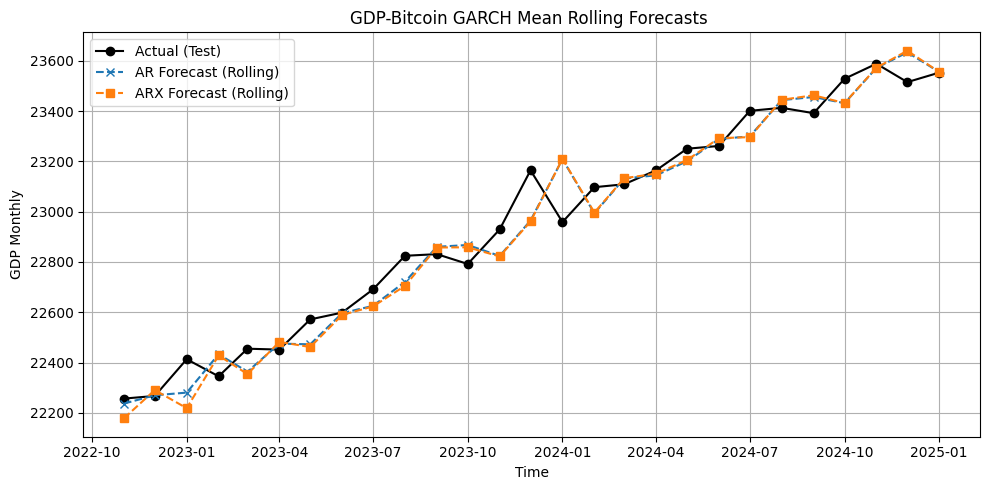

MAPE AR: 172.05%, ARX: 178.50%, ARX improvement: -3.75%


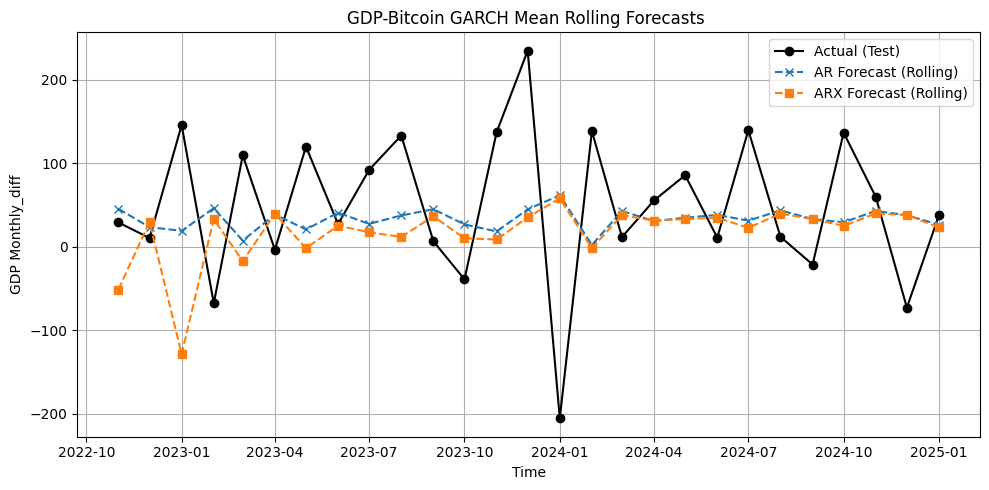

In [90]:
plot_garch_mean_predictions_rolling(df, 'GDP', 'Bitcoin', 'GDP Monthly', 1, 1)
plot_garch_mean_predictions_rolling(df, 'GDP', 'Bitcoin', 'GDP Monthly_diff', 1, 1)